# Course 4 - Project - Part 3: Visual search with k-NN

<a name="top-3"></a>
This notebook is concerned with *Part 3: Visual search with k-NN*.

**Contents:**
* [Step 0: Loading data](#step-3.0)
* [Step 1: Fit and tune a k-NN classifier](#step-3.1)
* [Step 2: Plot the 10 NNs of an image from the training set](#step-3.2)

## Loading data<a name="step-3.0"></a> ([top](#top-3))
---

We load the training set with the extracted high-level features.

In [1]:
# Standard library.
import os
import pathlib
import typing as T

# 3rd party.
import numpy as np

# Project.
import utils

In [2]:
separator = ''.center(80, '-')

path_train = pathlib.Path.cwd() / 'data' / 'swissroads-features-train.npz'
data_train = utils.load(path_train)
print(separator)
print(f'Dataset: train\n{utils.info(data_train)}')

path_valid = pathlib.Path.cwd() / 'data' / 'swissroads-features-valid.npz'
data_valid = utils.load(path_valid)
print(separator)
print(f'Dataset: valid\n{utils.info(data_valid)}')

path_test = pathlib.Path.cwd() / 'data' / 'swissroads-features-test.npz'
data_test = utils.load(path_test)
print(separator)
print(f'Dataset: test\n{utils.info(data_test)}')

--------------------------------------------------------------------------------
Dataset: train
data: shape=(280, 224, 224, 3), dtype=float32
labels: shape=(280,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(280, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: valid
data: shape=(139, 224, 224, 3), dtype=float32
labels: shape=(139,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(139, 1280), dtype=float32
--------------------------------------------------------------------------------
Dataset: test
data: shape=(50, 224, 224, 3), dtype=float32
labels: shape=(50,), dtype=int64
names: shape=(6,), dtype=<U10
features: shape=(50, 1280), dtype=float32


In [3]:
names = data_train['names']  # Same for all data sets.
assert (
    np.all(data_train['names'] == data_valid['names']) and
    np.all(data_train['names'] == data_test['names'])
)

X_train = data_train['data']
y_train = data_train['labels']
F_train = data_train['features']

X_valid = data_valid['data']
y_valid = data_valid['labels']
F_valid = data_valid['features']

X_test = data_test['data']
y_test = data_test['labels']
F_test = data_test['features']

## Step 1: Fit and tune a k-NN classifier<a name="step-3.1"></a> ([top](#top-3))
---

In [4]:
# Standard library.
import functools
import operator

# 3rd party.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import ticker 
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

We create a pipeline comprised of an optional scaler and a k-NN classifier.

In [5]:
# Create k-NN classifier.
knn = KNeighborsClassifier(
    # Let it pick the algorithm used to compute the nearest neighbors.
    algorithm='auto'
)

# Create the pipeline.
knn_pipe = Pipeline([
    ('scaler', None),
    ('knn', knn)
])

We perform a grid search.

In [6]:
scalers = [None, StandardScaler(), MinMaxScaler(), RobustScaler()]
knn_nns = np.arange(1, 20, 2)  # 1, 3, ..., 19

# Define the grid of values ot search.
grid = ParameterGrid([
    # Norm L1.
    {
        'scaler': scalers,
        'knn__n_neighbors': knn_nns,
        'knn__metric': ['minkowski'],
        'knn__p': [1]
    },
    # Norm L2.
    {
        'scaler': scalers,
        'knn__n_neighbors': knn_nns,
        'knn__metric': ['minkowski'],
        'knn__p': [2]
    }
])

In [7]:
gs_results = []

for params_dict in grid:
    # Set the parameters.
    knn_pipe.set_params(**params_dict)
    
    # Fit the clasifier to the data.
    knn_pipe.fit(F_train, y_train)
    
    # Store the scores.
    gs_result = params_dict
    gs_result['train_accuracy'] = knn_pipe.score(F_train, y_train)
    gs_result['valid_accuracy'] = knn_pipe.score(F_valid, y_valid)
    
    # Save result.
    gs_results.append(gs_result)

We convert the results to a data frame.

In [8]:
# Convert results to a data frame.
df_results = (pd
              .DataFrame(gs_results)
              .sort_values(by='valid_accuracy', ascending=False)
             )
df_results.head()

,knn__metric,knn__n_neighbors,knn__p,scaler,train_accuracy,valid_accuracy
12,minkowski,7,1,None,0.907143,0.913669
56,minkowski,9,2,None,0.892857,0.906475
52,minkowski,7,2,None,0.910714,0.899281
60,minkowski,11,2,None,0.889286,0.899281
54,minkowski,7,2,"MinMaxScaler(copy=True, feature_range=(0, 1))",0.910714,0.899281


We find the scaler and metric that lead to the best accuracy on the training set.

In [9]:
# We get the best result.
idx_best = df_results['valid_accuracy'].idxmax()

# We get the best scaler and metric.
scaler_best, metric_best, p_best = df_results.loc[idx_best, ['scaler', 'knn__metric', 'knn__p']]


# We need to be careful: None values are never equal to other values in Pandas.
def eq(series: pd.Series, value: T.Optional[T.Any]) -> pd.Series:
    return series.isna() if value is None else series == value


has_params_best = functools.reduce(operator.and_, [
    eq(df_results['scaler'], scaler_best),
    eq(df_results['knn__metric'], metric_best),
    eq(df_results['knn__p'], p_best)
])

# We extract the results for the given scaler and metric.
df_results_best = df_results[has_params_best]

We define a helper function to plot a few images from each category.

In [10]:
def plot_validation_curves(df_results: pd.DataFrame) -> None:
    """\
    Plots the validation curves.
    
    Args:
        df_results: A data frame with the results of the grid search to display.
    """
    # Make sure the records are sorted by k in ascending order.
    df_results = df_results.sort_values(by='knn__n_neighbors')
    
    # Create a figure.
    fig, ax = plt.subplots()
    
    # Plot validation curves.
    ax.plot(df_results['knn__n_neighbors'], df_results['train_accuracy'], label='training curve')
    ax.plot(df_results['knn__n_neighbors'], df_results['valid_accuracy'], label='validation curve')
    
    # Add labels.
    ax.set_xlabel('k')
    ax.set_ylabel('accuracy')
    
    # Change the x-axis tick locator.
    ax.get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))

    # Add a marker for the best score.
    idx_best = df_results['valid_accuracy'].idxmax()
    k_best, valid_accuracy = df_results.loc[idx_best, ['knn__n_neighbors', 'valid_accuracy']]
    # The series that represents the row may have a wider type.
    k_best = int(k_best)
    ax.scatter(k_best, valid_accuracy, marker='x', c='red', zorder=10)

    # Add a legend and a title.
    ax.legend()
    ax.set_title(f'Best k: {k_best} with {valid_accuracy * 100:.1f} % accuracy')

    plt.show()

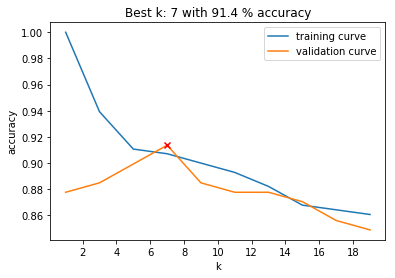

In [11]:
# We need to sort again.
plot_validation_curves(df_results_best)

We evaluate the accuracy of the best model on the test set.

In [12]:
# Gather the parameters.
keys = ['scaler', 'knn__n_neighbors', 'knn__metric', 'knn__p']
result_best = df_results.loc[idx_best]
params_best = {key: result_best[key] for key in keys}

# Initialize and fit.
knn_pipe.set_params(**params_best)
knn_pipe.fit(F_train, y_train)

# Evaluate on the test set.
test_accuracy = knn_pipe.score(F_test, y_test)
k_best = params_best['knn__n_neighbors']
print(f'Best k: {k_best} with {test_accuracy * 100:.1f} accuracy on the test set')

Best k: 7 with 92.0 accuracy on the test set


## Step 2: Plot the 10 NNs of an image from the training set<a name="step-3.2"></a> ([top](#top-3))
---

Pick an image from the test set and plot its 10 nearest neighbors from the train set

In [13]:
np.append(np.array(12), np.array([13,14]))

array([12, 13, 14])

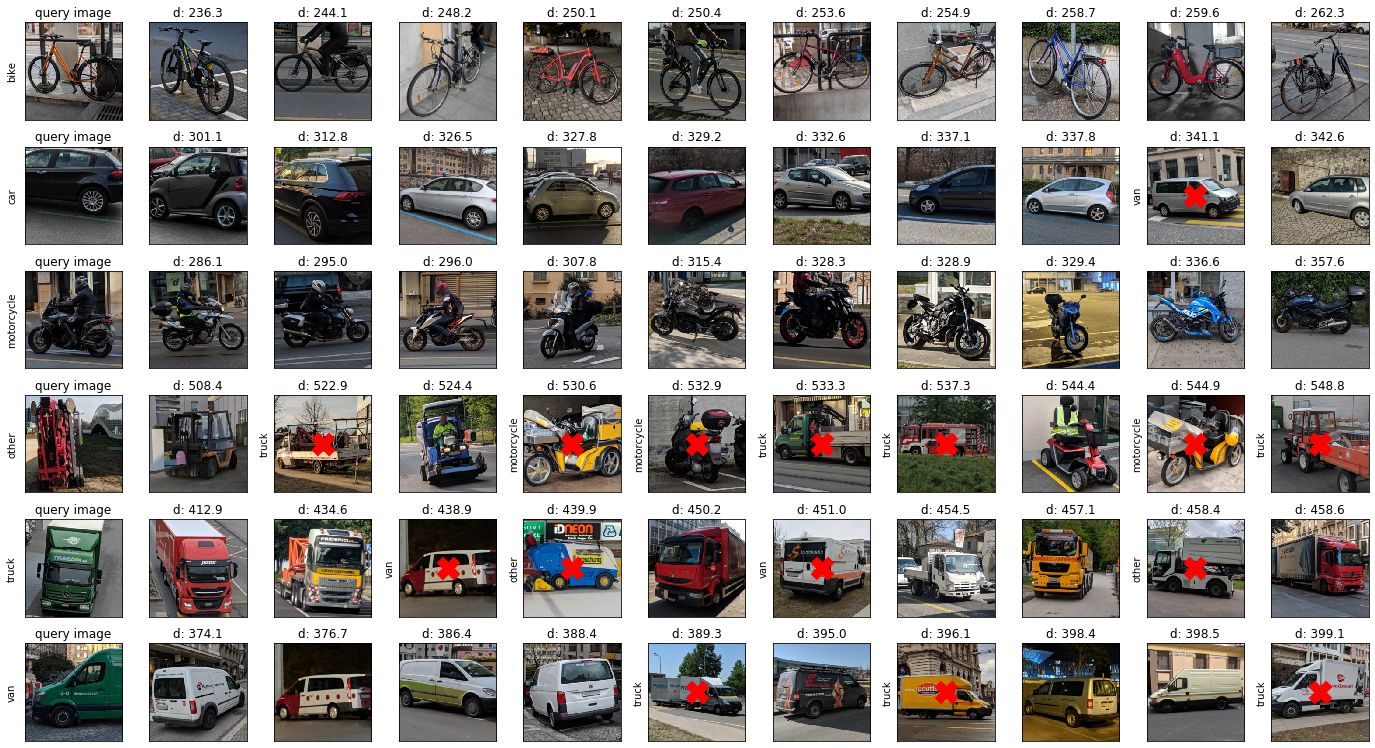

In [14]:
# We will plot the 10 nearest neighbors of 1 randomly chosen image from each category.
N_NEIGHBORS = 10

CELL_WIDTH = 1.75
CELL_HEIGHT = 1.75

# Make it deterministic.
np.random.seed(0)

nrows = len(names)
ncols = 1 + N_NEIGHBORS

scaler = knn_pipe.named_steps['scaler']
knn = knn_pipe.named_steps['knn']

fig, axs = plt.subplots(nrows=nrows, ncols=ncols,
                        figsize=(ncols * CELL_WIDTH, nrows * CELL_HEIGHT),
                        sharex=True, sharey=True)

for label in range(nrows):
    axs_cat = axs[label, :]
    
    # Randomly choose the index of an image that belongs to this category.
    (idxs,) = np.nonzero(y_test == label)
    idx_cat = np.random.choice(idxs)  # Pick a a single value.
    
    # Get the corresponding image and its high-level features.
    X_cat = X_test[idx_cat]
    F_cat = F_test[idx_cat]  # shape=(1280,)
    F_cat = F_cat[np.newaxis, :]  # shape=(1, 1280)
    
    if scaler:
        F_cat = scaler.transform(F_cat)
    dists_nn, idxs_nn = knn.kneighbors(F_cat, n_neighbors=N_NEIGHBORS,
                                       return_distance=True)
    dists_nn = dists_nn.squeeze()  # shape=(10,)
    idxs_nn = idxs_nn.squeeze()  # shape=(10,)
    
    # Display the images.
    for j, ax_cat in enumerate(axs_cat):
        if j == 0:
            # Show the query image.
            ax_cat.imshow(X_cat)
            
            # Add labels and title.
#             ax_cat.set_xlabel(f'idx: {cat_idx:03d}', fontsize=9)
            ax_cat.set_ylabel(names[label])
            ax_cat.set_title('query image')
        else:
            # Show the nearest neighbor.
            idx_nn = idxs_nn[j - 1]
            dist_nn = dists_nn[j - 1]
            ax_cat.imshow(X_train[idx_nn])
            
            # Add labels and title.
#             ax_cat.set_xlabel(f'idx: {idx_nn:03d}', fontsize=9)
            got_label = y_train[idx_nn]
            # Flag the image if we got the category wrong.
            if got_label != label:
                ax_cat.set_ylabel(names[got_label])
                ax_cat.scatter(224/2, 224/2, s=500, c='red', marker='X')
            ax_cat.set_title(f'd: {dist_nn:.1f}') 
        
        # X/y-axis: hide the ticks and their labels.
        ax_cat.tick_params(axis='both', which='both', length=0)
        ax_cat.set_xticklabels([])
        ax_cat.set_yticklabels([])

fig.tight_layout()
plt.show()

**Comment:** In this case, although some of the nearest neighbords do not belong to the same category as the query image, the first nearest neighbor always does.